I had posted my very naive baseline at https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019. In that kernel I only used the mode label for each Assessment and I thought it should be very easy to beat. This kernel shows how you can beat that baseline by actually applying a model. In this kernel via `get_data()` function, I go over each `installation_id` and try to extract some features based on his/her behavior prior to the assessment. I will then train a `Catboost` classifier on it and make predictions on the test set. Note that the features I made in this kernel are so very basic and you can easily add many more to it. Good luck and happy kaggling. Don't forget to upvote if you found it useful ;)

In [1]:
import numpy as np
import pandas as pd
import datetime

from time import time
from tqdm import tqdm_notebook as tqdm

In [2]:
from catboost import CatBoostClassifier

In [3]:
from sklearn.metrics import confusion_matrix
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)
    

In [4]:
train = pd.read_csv('data/raw/train.csv')
train_labels = pd.read_csv('data/raw/train_labels.csv')
specs = pd.read_csv('data/raw/specs.csv')
test = pd.read_csv('data/raw/test.csv')
submission = pd.read_csv('data/raw/sample_submission.csv')

In [5]:
# encode title
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [6]:
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [7]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [8]:
# no intersection between installation ids of train and test

In [9]:
# user_sample = train.query('installation_id=="0006a69f"')
# user_sample = test.query('installation_id=="01242218"') 

In [10]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else:
            if len(session)>1:
                second_condition = True
            else:
                second_condition= False
            
        if (session_type == 'Assessment') & (second_condition):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            features = user_activities_count.copy()
    #         features['installation_id'] = session['installation_id'].iloc[0]
#             features['game_session'] = i
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1

            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            if test_set == True:
                all_assessments.append(features)
            else:
                if true_attempts+false_attempts > 0:
                    all_assessments.append(features)
                
            counter += 1

    #         break

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

    if test_set:
        return all_assessments[-1] 
    return all_assessments

In [14]:
compiled_data = []
for i, (ins_id, user_sample) in enumerate(train.groupby('installation_id', sort=False)):
    compiled_data += get_data(user_sample)

In [15]:
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

(17690, 16)

Below are the features I have generated. Note that all of them are **prior** to each event. For example, the first row shows **before** this assessment, the player have watched 3 clips, did 3 activities, played 4 games and solved 0 assessments, so on so forth.

In [17]:
new_train.head()

,Activity,Assessment,Clip,Game,accumulated_accuracy,accumulated_correct_attempts,accumulated_uncorrect_attempts,accuracy_group,duration_mean,session_title,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,3,0,11,4,0.0,0,0,3,0.00,2,0,0,0,0,0.0,647
1,4,1,14,6,1.0,1,0,0,39.00,38,0,0,0,1,3.0,1143
2,4,2,14,6,0.5,1,11,3,65.50,2,1,0,0,1,1.5,1230
3,9,4,24,10,0.5,2,11,2,41.25,2,2,0,0,2,1.5,2159
4,10,5,28,13,0.5,3,12,3,39.20,38,2,0,1,2,1.6,2586


## Model

In [18]:
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
cat_features = ['session_title']
X, y = new_train[all_features], new_train['accuracy_group']
del train

In [19]:
def make_classifier():
    clf = CatBoostClassifier(
                               loss_function='MultiClass',
    #                            eval_metric="AUC",
                               task_type="CPU",
                               learning_rate=0.01,
                               iterations=2000,
                               od_type="Iter",
#                                depth=8,
                               early_stopping_rounds=500,
    #                            l2_leaf_reg=1,
    #                            border_count=96,
                               random_seed=2019
                              )
        
    return clf
oof = np.zeros(len(X))

In [20]:
# CV
from sklearn.model_selection import KFold
# preds = np.zeros(len(X_test))
oof = np.zeros(len(X))
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f'Training on fold {fold+1}')
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True, verbose=500, cat_features=cat_features)
    
#     preds += clf.predict(X_test).reshape(len(X_test))/NFOLDS
    oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('OOF QWK:', qwk(y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 1.3792156	test: 1.3792831	best: 1.3792831 (0)	total: 61.7ms	remaining: 2m 3s
500:	learn: 1.0059089	test: 1.0404665	best: 1.0404665 (500)	total: 4.24s	remaining: 12.7s
1000:	learn: 0.9798083	test: 1.0366899	best: 1.0366791 (995)	total: 8.57s	remaining: 8.55s
1500:	learn: 0.9544995	test: 1.0360636	best: 1.0359872 (1489)	total: 13.1s	remaining: 4.36s
1999:	learn: 0.9342808	test: 1.0361577	best: 1.0359125 (1779)	total: 17.7s	remaining: 0us

bestTest = 1.0359125
bestIteration = 1779

Shrink model to first 1780 iterations.
Fold 1 finished in 0:00:18.422760
Training on fold 2
0:	learn: 1.3790358	test: 1.3793581	best: 1.3793581 (0)	total: 47ms	remaining: 1m 33s
500:	learn: 1.0055512	test: 1.0450739	best: 1.0450739 (500)	total: 4.34s	remaining: 13s
1000:	learn: 0.9815060	test: 1.0374748	best: 1.0374748 (1000)	total: 8.64s	remaining: 8.62s
1500:	learn: 0.9582482	test: 1.0338483	best: 1.0338483 (1500)	total: 13.1s	remaining: 4.36s
1999:	learn: 0.9390875	test: 1.032330

Note that Cross validation is only for the feature engineering part and you don't actually need it if you want to submit the results. You can safely comment it out. 

In [21]:
# train model on all data once
clf = make_classifier()
clf.fit(X, y, verbose=500, cat_features=cat_features)

del X, y

0:	learn: 1.3788944	total: 10.4ms	remaining: 20.8s
500:	learn: 1.0113751	total: 4.46s	remaining: 13.4s
1000:	learn: 0.9884274	total: 9.04s	remaining: 9.02s
1500:	learn: 0.9673447	total: 13.8s	remaining: 4.59s
1999:	learn: 0.9499074	total: 18.6s	remaining: 0us


In [23]:
# process test set
new_test = []
for ins_id, user_sample in test.groupby('installation_id', sort=False):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [24]:
# make predictions on test set once
preds = clf.predict(X_test)
del X_test

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=8]=30.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

## Make submission

In [19]:
submission['accuracy_group'] = np.round(preds).astype('int')
submission.to_csv('submission.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


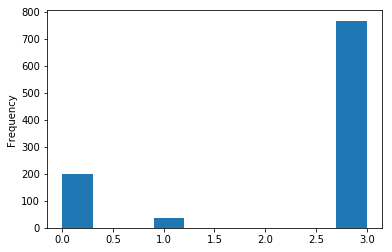

In [20]:
submission['accuracy_group'].plot(kind='hist')

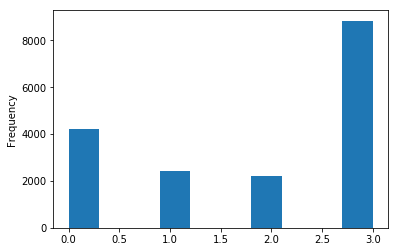

In [21]:
train_labels['accuracy_group'].plot(kind='hist')

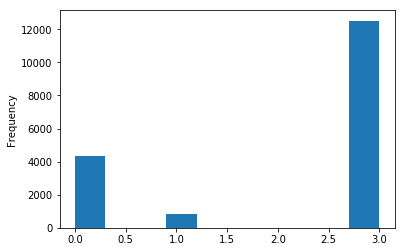

In [22]:
pd.Series(oof).plot(kind='hist')